In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
DATA_PATH = "/home/ubuntu/brats_2018_on_intel/data/processed/Task01_BrainTumour/"
DATA_DIR = "/home/ubuntu/brats_2018_on_intel/data/processed/"
DATASET = "Task01_BrainTumour/"

TRAIN_TEST_SPLIT = 0.80
VALIDATE_TEST_SPLIT = 0.50

BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VALIDATE = 4
BATCH_SIZE_TEST = 1

TILE_HEIGHT = 144
TILE_WIDTH = 144
TILE_DEPTH = 144
NUMBER_INPUT_CHANNELS = 1

CROP_DIM = (TILE_HEIGHT,TILE_WIDTH,TILE_DEPTH,NUMBER_INPUT_CHANNELS)

NUMBER_OUTPUT_CLASSES = 1


MODEL_DIR = "/home/ubuntu/brats_2018_on_intel/models"
SAVED_MODEL_NAME = "3d_unet_decathlon"
SELECTED_MODEL_EPOCH = 27

FILTERS = 16
NUM_EPOCHS = 40

RANDOM_SEED = 64

OUTPUT_DIR = Path("/home/ubuntu/brats_2018_on_intel/models/openvino")
IR_MODEL_PRECISION = "FP32"

In [3]:
import pickle

prediction_results_path = Path(Path(os.getenv('PWD')) / "reports" / "prediction_results.pkl")

with open(prediction_results_path, 'rb') as infile:
    prediction_data = pickle.load(infile)

2022-09-08 21:15:20.806203: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-08 21:15:21.830408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
prediction_data.keys()

dict_keys(['img', 'msk', 'prediction_ov', 'dice_coef_ov', 'inference_time_ov', 'prediction_tf', 'dice_coef_tf', 'inference_time_tf'])

In [5]:
from ipywidgets import AppLayout, IntSlider, Layout, HBox
import ipywidgets as widgets


def plot_interactive_predictions(data, scan_num = 0, channel=0):
    img = data['img'][scan_num]
    msk = data['msk'][scan_num]
    
    prediction_ov = data['prediction_ov'][scan_num]
    dice_coef_ov = data['dice_coef_ov'][scan_num]
    inference_time_ov = data['inference_time_ov'][scan_num]
    
    prediction_tf = data['prediction_tf'][scan_num]
    dice_coef_tf = data['dice_coef_tf'][scan_num]
    inference_time_tf = data['inference_time_tf'][scan_num]

    
    channel=0
    
    
    scan = img[0, :, :, :, channel]
    max_scan = scan.shape[2]
    mid_scan = int(max_scan / 2)
    
    label = msk[0, :, :, :, 0]
    pred_ov = prediction_ov[0, :, :, :, 0]
    pred_tf = prediction_tf[0, :, :, :, 0]
    
    plt.ioff()
    fig, ax = plt.subplots(2, 2, figsize=(15, 15))
    plt.ion()
    
    ax[0, 0].set_title(f'Axial View Slice n.', fontsize=20)
    im = ax[0, 0].imshow(scan[:, :, mid_scan], cmap='gray')
    ax[0, 1].set_title(f'Ground Truth Label', fontsize=20)
    lbl = ax[0, 1].imshow(label[:, :, mid_scan], cmap='gray')
    ax[1, 0].set_title(f"TensorFlow Prediction\nFP32\nDice = {dice_coef_tf:.4f}\n\nInference time\n{inference_time_tf:.4f} msecs", fontsize=20)
    p_tf = ax[1, 0].imshow(pred_tf[:, :, mid_scan], cmap='gray')
    ax[1, 1].set_title(f"OpenVINO Prediction\nFP32\nDice = {dice_coef_ov:.4f}\n\nInference time\n{inference_time_ov:.4f} msecs", fontsize=20)
    p_ov = ax[1, 1].imshow(pred_ov[:, :, mid_scan], cmap='gray')
    
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


    fig.canvas.header_visible = False
    #fig.canvas.layout.min_height = '400px'
    fig.canvas.toolbar_visible = False
    
    def update(change):
        im.set_data(scan[:, :, change['new']])
        lbl.set_data(label[:, :, change['new']])
        p_ov.set_data(pred_ov[:, :, change['new']])
        p_tf.set_data(pred_tf[:, :, change['new']])
        fig.canvas.draw_idle()

        
        
    slider = widgets.IntSlider(orientation='vertical', \
        description='Slice #:', value=mid_scan, min=0, max=max_scan)

    slider.layout.margin = '0px 0px 0px 0px'
    slider.layout.height = '100%'
    
    slider.observe(update, names='value')
    
    
    viewer = HBox([slider, fig.canvas], layout=Layout(align_items='center'))


    return viewer

In [6]:
%matplotlib widget
plot_interactive_predictions(prediction_data, scan_num=1)


In [7]:
def plot_ov_prediction_to_actual(data, channel=0, overlay_img=False):
    for i in range(len(data['img'])):
        img = data['img'][i]
        msk = data['msk'][i]    

        slicenum=np.argmax(np.sum(msk, axis=(1,2)))  # Find the slice with the largest tumor section
        prediction_ov = data['prediction_ov'][i]
        prediction_ov_offset = np.multiply(prediction_ov, 2)
        results = np.add(prediction_ov_offset,msk)

        from matplotlib import colors

        # make a color map of fixed colors
        cmap = colors.ListedColormap(['xkcd:black', "xkcd:red", 'xkcd:blue', 'xkcd:purple'])
        bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        
        if overlay_img == False:
            # tell imshow about color map so that only set colors are used
            masks = plt.imshow(results[0,:,:,slicenum,0], interpolation='nearest', origin='upper',
                                cmap=cmap, norm=norm)

        else:
            # tell imshow about color map so that only set colors are used
            results_mask = np.ma.masked_where(results == 0, results)
            images = plt.imshow(img[0,:, :, slicenum,0], cmap='gray')
            masks = plt.imshow(results_mask[0,:,:,slicenum,0], interpolation='nearest', origin='upper',
                                cmap=cmap, norm=norm, alpha = .5)
        
        # make a color bar
        cbar = plt.colorbar(masks, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1, 2, 3])
        cbar.ax.set_yticklabels(['True Negatives', 'False Negatives', 'False Positives', 'True Positives'])  # vertically oriented colorbar

        plt.show()

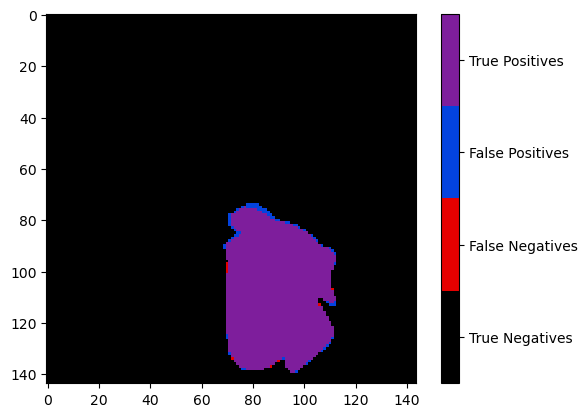

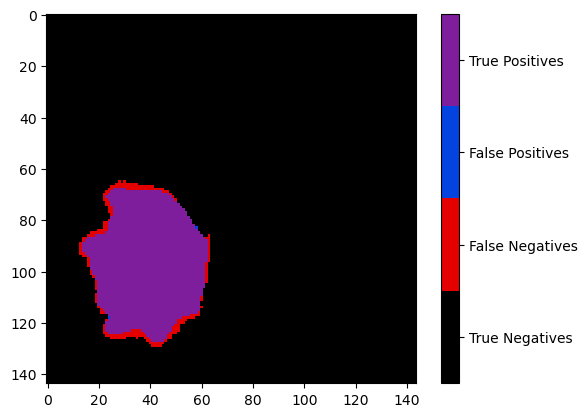

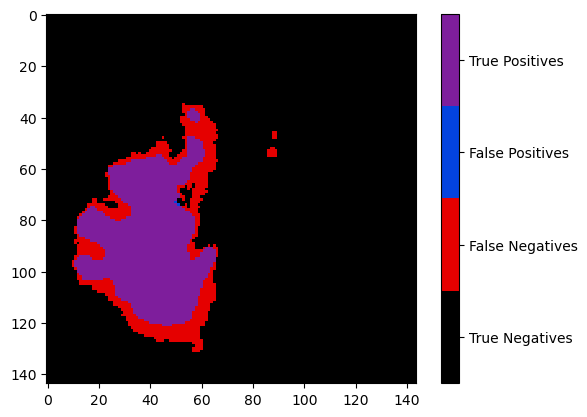

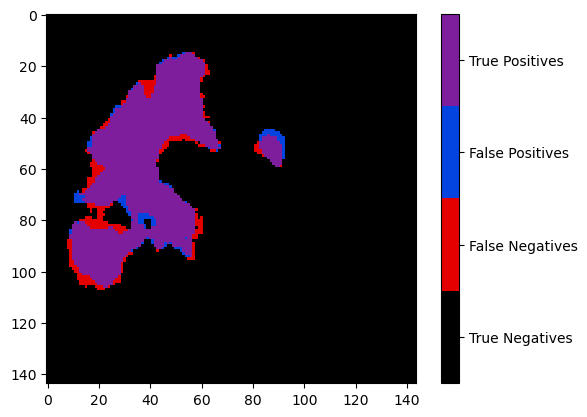

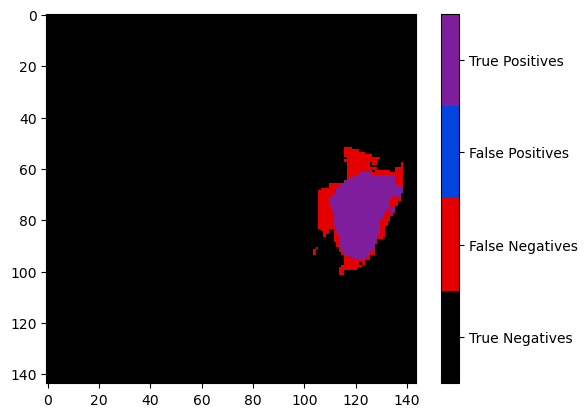

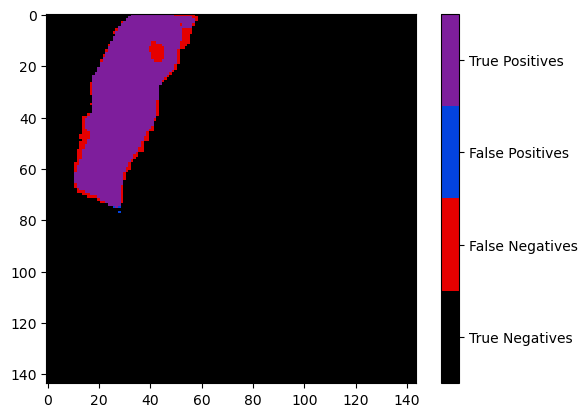

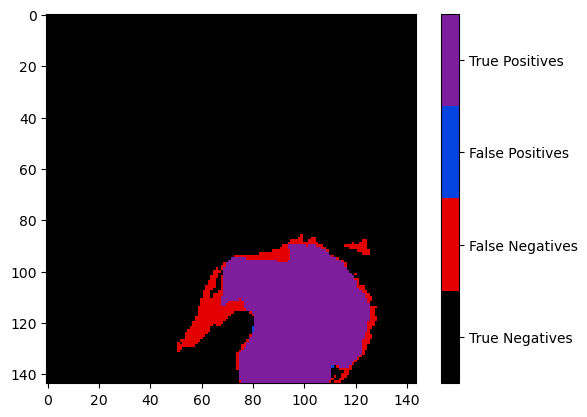

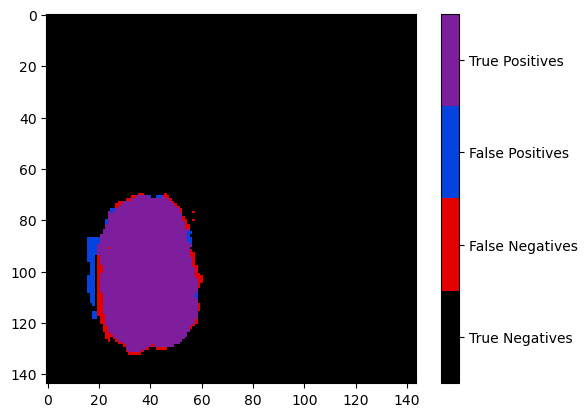

In [8]:
%matplotlib inline
plot_ov_prediction_to_actual(prediction_data)

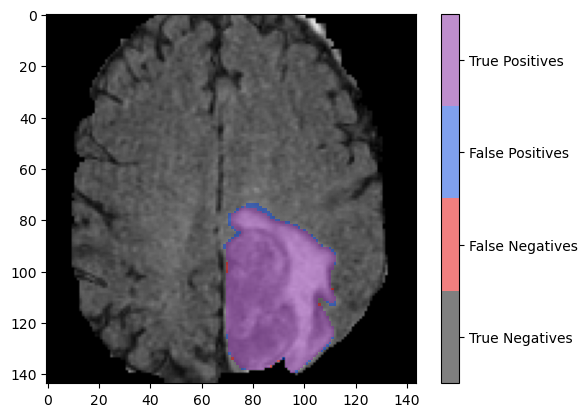

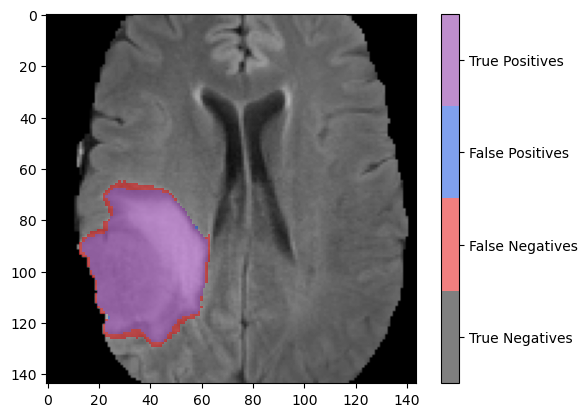

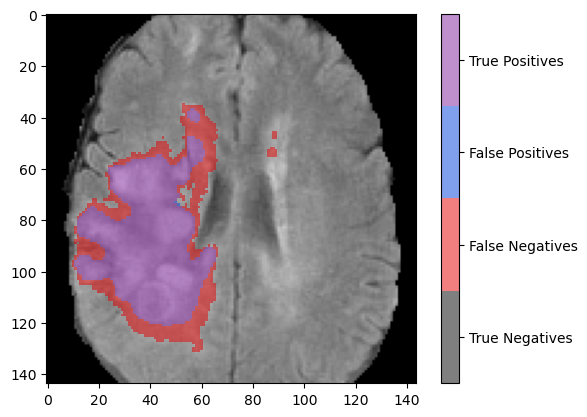

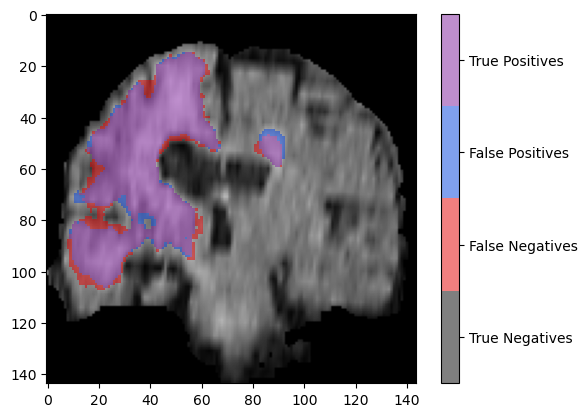

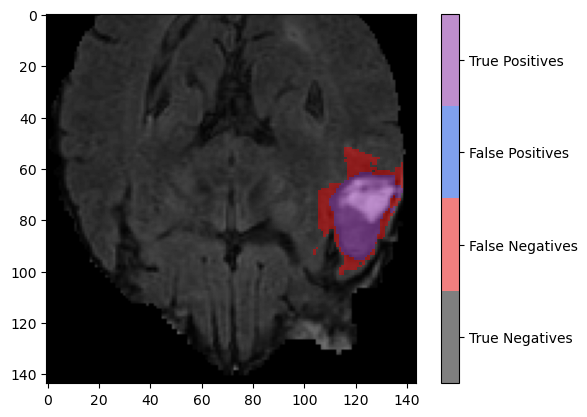

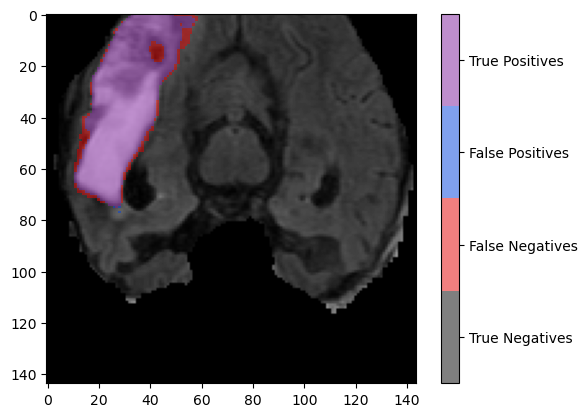

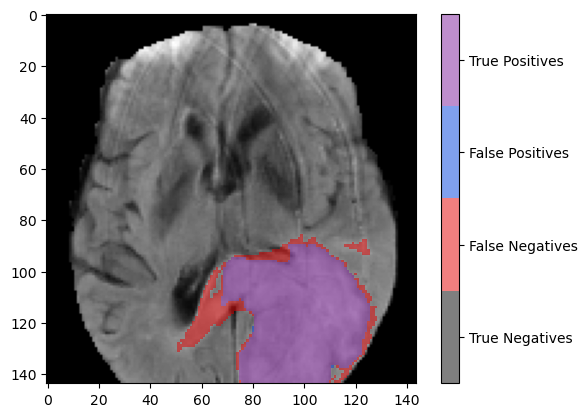

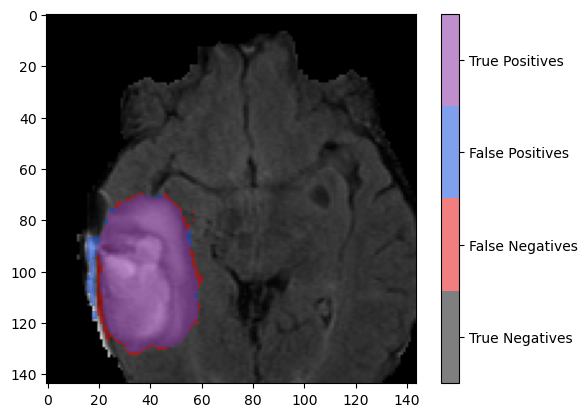

In [9]:
%matplotlib inline
plot_ov_prediction_to_actual(prediction_data, overlay_img=True)

In [10]:
from ipywidgets import AppLayout, IntSlider, Layout, HBox
import ipywidgets as widgets


def plot_interactive_masks_on_images(data, scan_num = 0, channel=0):
    img = data['img'][scan_num]
    msk = data['msk'][scan_num]
    prediction_ov = data['prediction_ov'][scan_num]
    precition_offset = np.multiply(prediction_ov, 2)
    results = np.add(precition_offset,msk)
    results_mask = np.ma.masked_where(results == 0, results)
    
    channel=0
    
    scan = img[0, :, :, :, channel]
    max_scan = scan.shape[2]
    mid_scan = int(max_scan / 2)
    
    from matplotlib import colors

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['xkcd:black', "xkcd:red", 'xkcd:blue', 'xkcd:purple'])
    bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    
    plt.ioff()
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plt.ion()
    
    # im = ax.imshow(scan[:, :, mid_scan], cmap='gray')
    # lbl = ax[0, 1].imshow(label[:, :, mid_scan], cmap='gray')
    
    # tell imshow about color map so that only set colors are used
    images = ax.imshow(img[0,:, :, mid_scan,0], cmap='gray')
    masks = ax.imshow(results_mask[0,:,:,mid_scan,0], interpolation='nearest', origin='upper',
                        cmap=cmap, norm=norm, alpha = .5)

    # make a color bar
    cbar = plt.colorbar(masks, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1, 2, 3], ax=ax)
    cbar.ax.set_yticklabels(['True Negatives', 'False Negatives', 'False Positives', 'True Positives'])  # vertically oriented colorbar
    
    fig.canvas.header_visible = False
    #fig.canvas.layout.min_height = '400px'
    fig.canvas.toolbar_visible = False
    
    def update(change):
        images.set_data(img[0, :, :, change['new'], 0])
        masks.set_data(results_mask[0, :, :, change['new'], 0])
        fig.canvas.draw_idle()

        
        
    slider = widgets.IntSlider(orientation='vertical', \
        description='Slice #:', value=mid_scan, min=0, max=max_scan)

    slider.layout.margin = '0px 0px 0px 0px'
    #slider.layout.margin = '20% 0px 20% 0px'
    slider.layout.height = '100%'
    
    slider.observe(update, names='value')
    
    
    viewer = HBox([slider, fig.canvas], layout=Layout(align_items='center'))


    return viewer

In [11]:
%matplotlib widget
plot_interactive_masks_on_images(prediction_data)

NameError: name 'xrange' is not defined

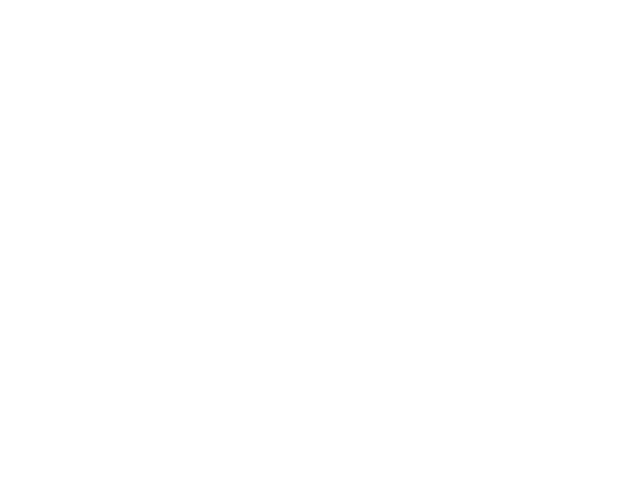

In [16]:
import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
for i in xrange(6):
    frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
# ani.save('movie.mp4')
plt.show()

In [ ]:
def show_prediction_video(data, channel=0):


    img = data['img']
    msk = data['msk']
    prediction_ov = np.round(data['prediction_ov'])
    precition_offset = np.multiply(prediction_ov, 2)
    results = np.add(precition_offset,msk)
    results_mask = np.ma.masked_where(results == 0, results)

    channel=0

    max_scan = img.shape[2]

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['xkcd:black', "xkcd:red", 'xkcd:blue', 'xkcd:purple'])
    bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)


    print(img.shape)
    fig, ax = plt.subplots(figsize=(8, 8))
    for i in range(max_scan):
        ax.cla()
        ax.imshow(img[0, :, :, i, channel], cmap='gray')
        # ax.imshow(results_mask[0,:,:,i+1, channel], interpolation='nearest', origin='upper',
        #                     cmap=cmap, norm=norm, alpha = .5)
        ax.set_title(f"Axial Slice #{i}")
        #plt.show()
        plt.pause(0.2)
    #cbar = plt.colorbar(masks, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1, 2, 3], ax=ax)
    #cbar.ax.set_yticklabels(['True Negatives', 'False Negatives', 'False Positives', 'True Positives'])  # vertically oriented colorbar





In [ ]:
%matplotlib inline
show_prediction_video(prediction_data)